# Calculating the variance of $err$ for sparse matrices. 

For a description of the algorithm, see the original notebook for non-sparse matrices

In [1]:
from __future__ import print_function
import numpy as np
import itertools as it
import sympy
import time

# Pretty latex printing (only for output, not for "print()")
sympy.init_printing(use_unicode=False, wrap_line=False, no_global=True)

# Define sympy symbols
# Symbolic variable for network size
S = sympy.symbols('S')
# Moments of off-diagonal elements
mu4, mu3, mu2, mu           = sympy.symbols('mu4 mu3 mu2 mu')
# Moments of diagonal elements
mu_d4, mu_d3, mu_d2, mu_d   = sympy.symbols('mu_d4 mu_d3 mu_d2 mu_d')
# Correlation terms (check code for the definition of rho_21, rho_22, rho_31)
rho, rho_21, rho_22, rho_31 = sympy.symbols('rho rho_21 rho_22 rho_31')

# Sparsity / connectivity / density
C = sympy.symbols('C')


## Define functions

In [2]:
def calc_multiplicity(P):
    dim_P = len(P)

    indices = set(range(dim_P))

    # Initial clique containing the first index
    cliques = [set([i for i in range(0, dim_P) if (i == 0 or P[0, i])])]

    # Form other cliques
    for i in range(dim_P):
        if set.union(*cliques) == indices:
            break
        else:
            idx = min(indices - set.union(*cliques))
            cliques.append(set([i for i in range(idx, dim_P) if (i == idx or P[idx, i])]))

    # Collapse cliques
    sorted_clique_len   = np.sort([len(clique) for clique in cliques])[::-1]
    multiplicity        = len(sorted_clique_len)
    
    return multiplicity

In [3]:
def collapse(P):
    dim_P = len(P)
    
    if dim_P in [3, 4]:
        dim_R = 2
    elif dim_P in [6, 7, 8]:
        dim_R = 4
    else: 
        raise Exception("P has wrong dimension!")
    
    R = np.zeros((dim_R, dim_R), dtype=bool)
    
    if dim_P == 3:
        # For denominator: collapse 6d to 4d: 
        # A_ia A_aj
        #     i, j  = 0, 1
        #     a     = 2

        # Upper triangle: equality
        R[0, 1] = P[0, 2] and P[1, 2]

        # Diagonal: diagonal entry A_ii
        R[0, 0] = P[0, 2]
        R[1, 1] = P[1, 2]

        # Lower triangle: transposed entries
        R[1, 0] = P[0, 1] and ~R[0, 1]
    
    if dim_P == 4:
        # For denominator: collapse 6d to 4d: 
        # A_ij A_kl
        #     i, j, k, l  = 0, 1, 2, 3

        # Upper triangle: equality
        R[0, 1] = P[0, 2] and P[1, 3]

        # Diagonal: diagonal entry A_ii
        R[0, 0] = P[0, 1]
        R[1, 1] = P[2, 3]

        # Lower triangle: transposed entries
        R[1, 0] = P[0, 3] and P[1, 2] and ~R[0, 1]
        
    if dim_P == 6:
        # For denominator: collapse 6d to 4d: 
        # A_ia A_aj A_kb A_bl
        #     i, j, k, l = 0, 1, 2, 3
        #     a, b       = 4, 5

        # Upper triangle: equality
        R[0, 1] = P[0, 4] and P[1, 4]
        R[0, 2] = P[0, 2] and P[4, 5]
        R[0, 3] = P[0, 5] and P[3, 4]
        R[1, 2] = P[2, 4] and P[1, 5]
        R[1, 3] = P[4, 5] and P[1, 3]
        R[2, 3] = P[2, 5] and P[3, 5]

        # Diagonal: diagonal entry A_ii
        R[0, 0] = P[0, 4]
        R[1, 1] = P[1, 4]
        R[2, 2] = P[2, 5]
        R[3, 3] = P[3, 5]

        # Lower triangle: transposed entries
        R[1, 0] = P[0, 1]             and ~R[0, 1]
        R[2, 0] = P[0, 5] and P[2, 4] and ~R[0, 2] 
        R[3, 0] = P[0, 3] and P[4, 5] and ~R[0, 3]
        R[2, 1] = P[1, 2] and P[4, 5] and ~R[1, 2]
        R[3, 1] = P[1, 5] and P[3, 4] and ~R[1, 3]
        R[3, 2] = P[2, 3]             and ~R[2, 3]

    if dim_P == 7:
        # For den * num term: collapse 7d to 4d
        # A_ij A_kl A_ma A_an
        #   i, j, k, l, m, n = 0, 1, 2, 3, 4, 5
        #   a                = 6

        # Upper triangle: equality
        R[0, 1] = P[0, 2] and P[1, 3] #R[0, 1]
        R[0, 2] = P[0, 4] and P[1, 6] #R[0, 2]
        R[0, 3] = P[0, 6] and P[1, 5] #R[0, 3]
        R[1, 2] = P[2, 4] and P[3, 6] #R[1, 2]
        R[1, 3] = P[2, 6] and P[3, 5] #R[1, 3]
        R[2, 3] = P[4, 6] and P[5, 6] #R[2, 3]

        # Diagonal: diagonal entry A_ii
        R[0, 0] = P[0, 1]
        R[1, 1] = P[2, 3]
        R[2, 2] = P[4, 6]
        R[3, 3] = P[5, 6]

        # Lower triangle: transposed entries
        R[1, 0] = P[0, 3] and P[1, 2] and ~R[0, 1]
        R[2, 0] = P[0, 6] and P[1, 4] and ~R[0, 2]
        R[3, 0] = P[0, 5] and P[1, 6] and ~R[0, 3]
        R[2, 1] = P[2, 6] and P[3, 4] and ~R[1, 2]
        R[3, 1] = P[2, 5] and P[3, 6] and ~R[1, 3]
        R[3, 2] = P[4, 5]             and ~R[2, 3]

    if dim_P == 8:
        # For num^2 term: collapse 8d to 4d
        # A_ij A_kl A_mn A_op
        #   i, j, k, l, m, n, o, p = 0, 1, 2, 3, 4, 5, 6, 7

        # Upper triangle: equality
        R[0, 1] = P[0, 2] and P[1, 3] #R[0, 1]
        R[0, 2] = P[0, 4] and P[1, 5] #R[0, 2]
        R[0, 3] = P[0, 6] and P[1, 7] #R[0, 3]
        R[1, 2] = P[2, 4] and P[3, 5] #R[1, 2]
        R[1, 3] = P[2, 6] and P[3, 7] #R[1, 3]
        R[2, 3] = P[4, 6] and P[5, 7] #R[2, 3]

        # Diagonal: diagonal entry A_ii
        R[0, 0] = P[0, 1]
        R[1, 1] = P[2, 3]
        R[2, 2] = P[4, 5]
        R[3, 3] = P[6, 7]

        # Lower triangle: transposed entries
        R[1, 0] = P[0, 3] and P[1, 2] and ~R[0, 1]
        R[2, 0] = P[0, 5] and P[1, 4] and ~R[0, 2]
        R[3, 0] = P[0, 7] and P[1, 6] and ~R[0, 3]
        R[2, 1] = P[2, 5] and P[3, 4] and ~R[1, 2]
        R[3, 1] = P[2, 7] and P[3, 6] and ~R[1, 3]
        R[3, 2] = P[4, 7] and P[5, 6] and ~R[2, 3]

    return R
    

In [4]:
def calc_indicators(P):

    dim_P   = len(P)
    idxs_all= np.arange(dim_P)
    # Final indicators
    i_all = []

    ### Off-diagonals
    # Separate as encoded by the diagonal of P. 
    idxs = set(idxs_all[~np.diag(P)])
    if len(idxs) > 0:

        # Get sorted clique lengths
        # Start with initial clique
        # Index of entry to refer to
        i_ref   = min(idxs)
        i_refs  = [i_ref]
        # All indices for which the correspoding random variables are equal, 
        # as encoded by the upper triangle of P. 
        cliques = [set([j for j in idxs if (i_ref == j or P[i_ref, j])])]

        # Form other cliques
        while(set.union(*cliques) != idxs):
            # Take only those indices not yet assigned to cliques
            idxs_red    = idxs - set.union(*cliques)
            # Reference: the minimum of the remaining. 
            i_ref       = min(idxs_red)
            i_refs.append(i_ref)
            cliques.append(set([j for j in idxs_red if (i_ref == j or P[i_ref, j])]))

        # Sorted clique lengths (largest ones first)
        scl = np.sort([len(clique) for clique in cliques])[::-1]

        i_refs = np.asarray(i_refs)


        # Check for transposes
        uscl = np.sort(np.unique(scl))[::-1]
        prev_js = []
        # Break up in blocks of equal clique length (descending)
        for cl in uscl:
            # Temporary indicators for this clique length
            i_temp = np.asarray([])
            for i in i_refs[scl == cl]: 
                if not i in prev_js:
                    # List of all indices from other cliques whose variable 
                    # is the transpose of the i-th variale (as encoded inthe lower triangle of P)
                    # Note: Only descending indices are taken to avoid double counting.
                    js = [j for j in i_refs[i_refs > i] if P[j, i]]
                    prev_js.append(js)
                    if len(js) > 0:
                        # Prepend this variable(s) and corresponding partner(s) (according to each clique lenght). 
                        # The previous indicators are raised by one. 
                        i_temp += 1.
                        i_temp = np.concatenate((
                                np.repeat([0., 0.1], [cl, scl[np.where(i_refs == min(js))[0]]]), 
                                i_temp))
                    elif len(i_temp) > 0:
                        # No partners. Append the clique, indicator is 1 + the maximal existing. 
                        i_temp = np.append(i_temp, np.repeat(np.max(np.floor(i_temp)) + 1., cl))
                    else:
                        # No partners and no existing indicators. Start with 0. 
                        i_temp = np.repeat(0., cl)
        #             print(cl, i, js, i_temp)

            # Add to list of indicators from higher clique lengths. 
            if len(i_all) > 0:
                # Raise indices to be added by 1 + maximal existing.
                i_temp += np.max(np.floor(i_all)) + 1.
            i_all = np.append(i_all, i_temp)

#     print("Before adding diagonal elements: i_all = ", i_all)

    ### Diagonal elements
    # Separate as encoded by the diagonal of P. 
    idxs = set(idxs_all[np.diag(P)])
    if len(idxs) > 0:

        ### Get sorted clique lengths
        # Initial clique containing the first index
        # Index of entry to refer to
        i_ref   = min(idxs)
        # All indices for which the correspoding random variables are equal, 
        # as encoded by the upper triangle of P. 
        cliques = [set([j for j in idxs if (i_ref == j or P[i_ref, j])])]

        # Form other cliques
        while(set.union(*cliques) != idxs):
            # Take only those indices not yet assigned to cliques
            idxs_red    = idxs - set.union(*cliques)
            # Reference: the minimum of the remaining. 
            i_ref       = min(idxs_red)
            cliques.append(set([j for j in idxs_red if (i_ref == j or P[i_ref, j])]))

        # Sorted clique lengths (largest ones first)
        scl = np.sort([len(clique) for clique in cliques])[::-1]

        # Indicators for diagonal elements: cliques sorted by desceding length
        i_diag = np.repeat(np.arange(len(cliques), dtype = float), scl)
        if len(i_all) > 0:
            # Raise indices to be added by 1 + maximal existing.
            i_diag += np.max(np.floor(i_all)) + 1.

        i_all = np.append(i_all, i_diag)

    # Add tag for the number of diagonal elements to the indicators
#     i_all = np.int_(i_all * 10)
    indicators = np.append(i_all, np.sum(np.diag(P)))

#     print("After adding diagonal elements: i_all = ", i_all)
#     print("Number of diagonal elements: %d"%n_diags)
    
    return tuple(indicators)

In [5]:
def calc_all(dim_P):
    """ Generate all possible iterations (only upper triangular matrices) 
    and throw away all inconsistent ones. If matrix is kept, set diagonal elements to `True`.
    """
    
    # Initialize list for saving indicators
    indicators = []
    
    # Make sure you're not filling the memory completely...
    assert dim_P <= 8, "Larger dim_P takes too long."
    
    
    # Number of entries in upper triangular matrix without diagonal
    red_dim = int(dim_P * (dim_P - 1) / 2.)
                  
    # Iterate over all possible realizations
    time0 = time.time()
    for entries in it.product([True, False], repeat = red_dim):
        P = np.zeros((dim_P, dim_P), dtype=bool)
        for i in range(dim_P - 1):
            si = sum(range(dim_P - 1 - i, dim_P - 1))
            P[i, i+1:] = entries[i + si: si + dim_P - 1]
    
        # Throw away inconsistent ones
        throw_away = False
        for x in range(dim_P-1):
            for y in range(x + 1, dim_P):
                for z in range(y + 1, dim_P):
                    if P[x, y] or P[x, z]:
                        if (P[x, y] and P[x, z]) != P[y, z]:
                            throw_away = True
                            break
                if throw_away:
                    break
            if throw_away:
                break
                
        if not throw_away:
            
            m_P = calc_multiplicity(P)
            
            R   = collapse(P)
            
            ind = calc_indicators(R)
            
            indicators.append([ind, m_P])
        
    print("For dim_P = %d -> red_dim = %d, the calculation took %.1f sec.\n"%(dim_P, red_dim, time.time() - time0))
    return np.asarray(indicators)


In [6]:
def print_results(indicators, dim_P):
    """ Print the results in a nice way (to understand what's going on).
    """
    dim_R = len(indicators[0, 0]) - 1
    
    from collections import OrderedDict

    if dim_R == 2:
        factors = OrderedDict([
            # Ordered by (1.) n_d, (2.) highest clique length

            ((0  , 1  , 0), C**2 * mu**2),
            ((0  , 0.1, 0), C**2 * (rho * mu2 + mu**2)),
            ((0  , 0  , 0), C    * (mu2 + mu**2)),

            ((0  , 1  , 1), C**2 * mu * mu_d),
                
            ((0  , 1  , 2), C**2 * mu_d**2),
            ((0  , 0  , 2), C    * (mu_d2 + mu_d**2)),
        ])
    elif dim_R == 4:
        factors = OrderedDict([
            # Ordered by (1.) n_d, (2.) highest clique length

            ((0  , 1  , 2  , 3  , 0), C**4 * mu**4), 
            ((0  , 0  , 1  , 2  , 0), C**3 * (mu2 + mu**2) * mu**2),
            ((0  , 0  , 1  , 1  , 0), C**2 * (mu2 + mu**2)**2),
            ((0  , 0  , 0  , 1  , 0), C**2 * (mu3 + 3 * mu2 * mu + mu**3) * mu),
            ((0  , 0  , 0  , 0  , 0), C    * (mu4 + 4 * mu3 * mu + 6 * mu2 * mu**2 + mu**4)),
            ((0  , 0.1, 1  , 2  , 0), C**4 * (rho * mu2 + mu**2) * mu**2),
            ((0  , 0.1, 1  , 1.1, 0), C**4 * (rho * mu2 + mu**2)**2),
            ((0  , 0  , 1  , 1.1, 0), C**3 * (mu2 + mu**2) * (rho * mu2 + mu**2)),
            ((0  , 0  , 0.1, 1  , 0), C**3 * (mu2 * (1 + rho_21) + mu**2) * mu**2),
            ((0  , 0  , 0.1, 0.1, 0), C**2 * ((mu2 + mu**2)**2 + rho_22)),
            ((0  , 0  , 0  , 0.1, 0), C**2 * ((mu3 + 3 * mu2 * mu + mu**3) * mu + rho_31)),   #
                
            ((0  , 1  , 2  , 3  , 1), C**4 * mu**3 * mu_d),
            ((0  , 0  , 1  , 2  , 1), C**3 * (mu2 + mu**2) * mu * mu_d),
            ((0  , 0  , 0  , 1  , 1), C**2 * (mu3 + 3 * mu2 * mu + mu**3) * mu_d),
            ((0  , 0.1, 1  , 2  , 1), C**4 * (rho * mu2 + mu**2) * mu * mu_d),
            ((0  , 0  , 0.1, 1  , 1), C**3 * (mu2 * (1 + rho_21) + mu**2) * mu * mu_d),   # 
                
            ((0  , 1  , 2  , 3  , 2), C**4 * mu**2 * mu_d**2),
            ((0  , 0  , 1  , 2  , 2), C**3 * (mu2 + mu**2) * mu_d**2),
            ((0  , 1  , 2  , 2  , 2), C**3 * mu**2 * (mu_d2 + mu_d**2)),
            ((0  , 0  , 1  , 1  , 2), C**2 * (mu2 + mu**2) * (mu_d2 + mu_d**2)),
            ((0  , 0.1, 1  , 2  , 2), C**4 * (rho * mu2 + mu**2) * mu_d**2),
            ((0  , 0.1, 1  , 1  , 2), C**3 * (rho * mu2 + mu**2) * (mu_d2 + mu_d**2)),   # 
                
            ((0  , 1  , 2  , 3  , 3), C**4 * mu * mu_d**3),
            ((0  , 1  , 1  , 2  , 3), C**3 * mu * (mu_d2 + mu_d**2) * mu_d),
            ((0  , 1  , 1  , 1  , 3), C**2 * mu * (mu_d3 + 3 * mu_d2 * mu_d + mu_d**3)),  # 
                
            ((0  , 1  , 2  , 3  , 4), C**4 * mu_d**4),
            ((0  , 0  , 1  , 2  , 4), C**3 * (mu_d2 + mu_d**2) * mu_d**2),
            ((0  , 0  , 1  , 1  , 4), C**2 * (mu_d2 + mu_d**2)**2),
            ((0  , 0  , 0  , 1  , 4), C**2 * (mu_d3 + 3 * mu_d2 * mu_d + mu_d**3) * mu_d),
            ((0  , 0  , 0  , 0  , 4), C    * (mu_d4 + 4 * mu_d3 * mu_d + 6 * mu_d2 * mu_d**2 + mu_d**4)),

            # ((0  , 0  , 0.1, 1  , 0), (mu**3 + mu2 * mu * (2 * rho + 1)) * mu), # GAUSS-SPECIFIC X X X^T Y
            # ((0  , 0  , 0.1, 0.1, 0), mu**4 + 2 * mu**2 * mu2 + mu2**2 + 2 * rho * (2 * mu**2 * mu2 + mu2**2 * rho)), # GAUSS-SPECIFIC X X X^T X^T
            # ((0  , 0  , 0  , 0.1, 0), mu**4 + 3 * mu2 * (rho * (mu2 + mu**2) + mu**2)), # GAUSS-SPECIFIC X X X X^T
            # ((0  , 0  , 0.1, 1  , 1), (mu**3 + mu2 * mu * (2 * rho + 1)) * mu_d), # GAUSS-SPECIFIC X X X^T Y_d
        ])
    
    tuples = factors.keys()

    print(" "*(dim_R + 1)*5 + "Multiplicity number m_P")
    m_p_str_title = ""
    for i in range(dim_P):
        m_p_str_title += "%5d"%(i+1)
    print("Cliques              " + m_p_str_title)
    print("-"*60)

    # Check if comparison works:
    for ind in indicators:
        if not ind[0] in tuples:
            print(ind)
            raise Exception("Not in tuples!")

    m_all = np.zeros((len(tuples), dim_P), dtype=int)
    for j, ind_tuple in enumerate(tuples):
        # Get multiplicities
        multiplicities = np.zeros(dim_P, dtype=int)
        for ind in indicators:
            if ind[0] == ind_tuple:
                multiplicities[ind[1] - 1] += 1

        # Generate indicator name
        i_str = ""
        nd = int(ind_tuple[-1])
        for i in range(dim_R):
            i_str += ['X', 'Y', 'Z', 'U'][int(np.floor(ind_tuple[i]))]

            if i < dim_R - nd:
                # Off-diagonals
                ind_i = ind_tuple[i]
                if round(ind_i - round(ind_i, 0), 1) == 0.1:
                    i_str += '^T'
                else:
                    i_str += '  '
            else:
                # Diagonals
                i_str += '_d'

            i_str += '  '

        # Generate string with multiplicities
        m_str = ""
        for m_c in multiplicities:
            if m_c == 0:
                m_str += "    -"
            else:
                m_str += "%5d"%m_c

        print(i_str + " " + m_str)

        m_all[j] = multiplicities
            
    return m_all, factors


In [7]:
def calc_expected_value(m_factors_all, factors):
    
    dim_P = m_factors_all.shape[1]
    j = sympy.symbols('j', integer=True)
    
    # Check-sum
    check_sum = 0
    m_factor_column_sum = np.sum(m_factors_all, axis=0)
    for i in range(dim_P):
        prod_S = sympy.product(S-j, (j, 0, i))
        check_sum += prod_S * m_factor_column_sum[i]
    
    if 1.0 * S**dim_P == sympy.expand(check_sum) or S**dim_P == sympy.expand(check_sum):
        print("\nChecksum = ", sympy.expand(check_sum), "is ok!") # == S**6???
    else:
        raise Exception("Checksum not ok!")

    # Calculate factors for expected value
    a = []
#     for k in range(len(m_factors_all)):
    for m_factors in m_factors_all:
        sum_S = 0
        for i in range(dim_P):
            prod_S = sympy.product(S-j, (j, 0, i))
            sum_S += prod_S * m_factors[i]
        a.append(sympy.expand(sum_S))

    # Expected_value 
    expected_value = 0
    for j, factor in enumerate(factors.values()):
        expected_value += factor * a[j]
        
    dim_R = len(factors.keys()[0]) - 1
    prefactor = S**(2 * dim_R - dim_P)
        
    return prefactor * expected_value

## Calculate expected values of $n$, $d$, $n^2$, $d^2$ and $n \cdot d$.

In [8]:
# Calculate d term
print("Calculate d term\n")

dim = 3

indicators = calc_all(dim)

m_factors_all, factors = print_results(indicators, dim_P=dim)

E_d = calc_expected_value(m_factors_all, factors)

# print("\nE[d]:")
# sympy.expand(E_d)


Calculate d term

For dim_P = 3 -> red_dim = 3, the calculation took 0.0 sec.

               Multiplicity number m_P
Cliques                  1    2    3
------------------------------------------------------------
X    Y         -    -    1
X    X^T       -    1    -
X    X         -    -    -
X    Y_d       -    2    -
X_d  Y_d       -    -    -
X_d  X_d       1    -    -

Checksum =  S**3 is ok!


In [9]:
# Calculate n term
print("Calculate n term\n")

dim = 4

indicators = calc_all(dim)

m_factors_all, factors = print_results(indicators, dim_P=dim)

E_n = calc_expected_value(m_factors_all, factors)

# print("\nE[n]:")
# sympy.expand(E_n)


Calculate n term

For dim_P = 4 -> red_dim = 6, the calculation took 0.0 sec.

               Multiplicity number m_P
Cliques                  1    2    3    4
------------------------------------------------------------
X    Y         -    -    4    1
X    X^T       -    1    -    -
X    X         -    1    -    -
X    Y_d       -    4    2    -
X_d  Y_d       -    1    -    -
X_d  X_d       1    -    -    -

Checksum =  S**4 is ok!


In [10]:
# Calculate d^2 term
print("Calculate d^2 term\n")

dim = 6

indicators = calc_all(dim)

m_factors_all, tuples = print_results(indicators, dim_P=dim)

E_d_sq = calc_expected_value(m_factors_all, tuples)

# print("\nE[d^2]:")
# sympy.expand(E_d_sq)


Calculate d^2 term

For dim_P = 6 -> red_dim = 15, the calculation took 1.0 sec.

                         Multiplicity number m_P
Cliques                  1    2    3    4    5    6
------------------------------------------------------------
X    Y    Z    U         -    -    -   10    9    1
X    X    Y    Z         -    -    2    4    -    -
X    X    Y    Y         -    -    1    -    -    -
X    X    X    Y         -    -    -    -    -    -
X    X    X    X         -    -    -    -    -    -
X    X^T  Y    Z         -    -    6   16    2    -
X    X^T  Y    Y^T       -    -    5    1    -    -
X    X    Y    Y^T       -    -    2    -    -    -
X    X    X^T  Y         -    -    6    -    -    -
X    X    X^T  X^T       -    2    -    -    -    -
X    X    X    X^T       -    -    -    -    -    -
X    Y    Z    U_d       -    -    8   24    4    -
X    X    Y    Z_d       -    -    8    -    -    -
X    X    X    Y_d       -    -    -    -    -    -
X    X^T  Y    Z_d       -  

In [11]:
# Calculate n*d term
print("Calculate n * d term\n")

dim = 7

indicators = calc_all(dim)

m_factors_all, tuples = print_results(indicators, dim_P=dim)

E_nd = calc_expected_value(m_factors_all, tuples)

# print("\nE[n*d]:")
# sympy.expand(E_nd)



Calculate n * d term

For dim_P = 7 -> red_dim = 21, the calculation took 62.5 sec.

                         Multiplicity number m_P
Cliques                  1    2    3    4    5    6    7
------------------------------------------------------------
X    Y    Z    U         -    -    -   48   64   16    1
X    X    Y    Z         -    -   10   30    5    -    -
X    X    Y    Y         -    -    2    -    -    -    -
X    X    X    Y         -    -    2    -    -    -    -
X    X    X    X         -    -    -    -    -    -    -
X    X^T  Y    Z         -    -   18   62   17    1    -
X    X^T  Y    Y^T       -    -    6    1    -    -    -
X    X    Y    Y^T       -    -   14    3    -    -    -
X    X    X^T  Y         -    -   16    2    -    -    -
X    X    X^T  X^T       -    2    -    -    -    -    -
X    X    X    X^T       -    2    -    -    -    -    -
X    Y    Z    U_d       -    -   28  116   46    4    -
X    X    Y    Z_d       -    -   36   10    -    -    -
X    X 

In [12]:
# Calculate n^2 term
print("Calculate n^2 term\n")

dim = 8

indicators = calc_all(dim)

m_factors_all, tuples = print_results(indicators, dim_P=dim)

E_n_sq = calc_expected_value(m_factors_all, tuples)

# print("\nE[n^2]:")
# sympy.expand(E_n_sq)


Calculate n^2 term

For dim_P = 8 -> red_dim = 28, the calculation took 8808.1 sec.

                         Multiplicity number m_P
Cliques                  1    2    3    4    5    6    7    8
------------------------------------------------------------
X    Y    Z    U         -    -    -  240  432  176   24    1
X    X    Y    Z         -    -   48  192   72    6    -    -
X    X    Y    Y         -    -   12    3    -    -    -    -
X    X    X    Y         -    -   16    4    -    -    -    -
X    X    X    X         -    1    -    -    -    -    -    -
X    X^T  Y    Z         -    -   48  192   72    6    -    -
X    X^T  Y    Y^T       -    -   12    3    -    -    -    -
X    X    Y    Y^T       -    -   24    6    -    -    -    -
X    X    X^T  Y         -    -   48   12    -    -    -    -
X    X    X^T  X^T       -    3    -    -    -    -    -    -
X    X    X    X^T       -    4    -    -    -    -    -    -
X    Y    Z    U_d       -    -   96  544  368   72    4    -

## Put everything together to get 

## $\mathrm{Var}(err) \approx 
\frac{\mathbb{E}[d^2]\mathbb{E}[n]^2 - 2 \mathbb{E}[nd]\mathbb{E}[n] \mathbb{E}[d] + \mathbb{E}[n^2]\mathbb{E}[d]^2}
{\mathbb{E}[d^2]\mathbb{E}[d]^2}$

### We approximate for different cases:

 * 0.)  Full variance, no further conditions. 
  
  
 * 1.)  All $A_{ij}$ iid, no correlation (test case).  
    $\mu_d = \mu, \quad \sigma_d = \sigma, \quad \rho = 0$ 


 * 2.)  Constant diagonal, no correlation  
    $\mu_d = -d, \quad \sigma_d = 0, \quad \rho = 0$  

  * 2a) Non-reactivity / D-stability for $\mu > 0 \sim$ cooperation:   
    $ d = (S - 1)\mu $
 
  * 2b) Non-reactivity / D-stability for $\mu \le 0 \sim$ competition:   
    $ d = \sigma \sqrt{2S(1 + \rho)} - \mu$


 * 3.) Mutualisitic correlation, no specific diagonal  
    $\mu_d = \mu, \quad \sigma_d = \sigma, \quad \rho \ne 0$ 


For each case, the variance is approximated to the highest and next to highest order. 

In [13]:
# Creating full numerator and denominator
full_num = sympy.expand(E_d_sq * E_n**2 - 2 * E_nd * E_n * E_d + E_n_sq * E_d**2)
full_den = sympy.expand(E_d_sq * E_d**2)


In [14]:
# Get highest order contribution.
def eval_specific_case(full_n, full_d, full_num, full_den, cond, show_order=0):
    
    # Make results more readable: exchange sigma**2 for mu2
    sigma, sigma_d = sympy.symbols('sigma sigma_d')
    cond_sigma = [(mu2, sigma**2), (mu_d2, sigma_d**2)]
    
    # Apply conditions 
    d_n = sympy.expand((full_d - full_n).subs(cond + cond_sigma))
    d   = sympy.expand(full_d.subs(cond + cond_sigma))
    num = sympy.expand(full_num.subs(cond + cond_sigma))
    den = sympy.expand(full_den.subs(cond + cond_sigma))

    # Get highest order of term (expected value or variance)
    def approx(num, den, order=0):
        if num == 0:
            deg_num = 0
        else:
            deg_num = sympy.degree(num, gen=S) - order
        num_approx  = num - (num + sympy.O(S**deg_num)).removeO()
        
        if den == 0:
            print("Deminator is zero!")
            return 0
        else:
            deg_den     = sympy.degree(den, gen=S) - order
        den_approx  = den - (den + sympy.O(S**deg_den)).removeO()
        
        min_deg     = min(deg_num, deg_den)
        if num == 0:
            min_deg_mu = 0
        else:
            min_deg_mu  = min(sympy.O(num_approx, (mu, 0)).getn(), sympy.O(den_approx, (mu, 0)).getn())
        approx      = (sympy.factor(num_approx / (S**min_deg * mu**min_deg_mu)) / 
                       sympy.factor(den_approx / (S**min_deg * mu**min_deg_mu)))
        return approx
    
    if show_order == 0:
        print("\nExpected value: 1st order; Variance: 1st order.")
        return (approx(d_n, d, order=0), 
                approx(num, den, order=0),
                )
    
    elif show_order == 1:
        print("\nExpected value: 1st & 2nd order; Variance: 1st & 2nd order.")
        return (approx(d_n, d, order=0), 
                approx(d_n, d, order=1), 
                approx(num, den, order=0),
                approx(num, den, order=1),
                )
    

    elif show_order == 2:
        print("\nExpected value: 1st & 2nd order, full; Variance: 1st & 2nd order, full.")
        return (approx(d_n, d, order=0), 
                approx(d_n, d, order=1), 
                d_n / d,
                approx(num, den, order=0),
                approx(num, den, order=1),
                num / den,
                )


Case 0: Full variance, no further conditions.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


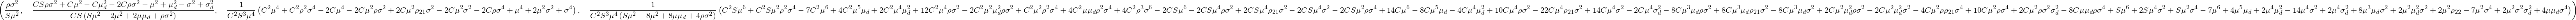

In [15]:
# 0.
print("Case 0: Full variance, no further conditions.")

cond = []

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 1: All A_ij iid.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


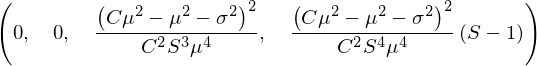

In [16]:
# 1.
print("Case 1: All A_ij iid.")
cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4), (rho, 0), (rho_21, 0), (rho_22, 0), (rho_31, 0)]

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 2: correlation variables, no specific diagonal.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


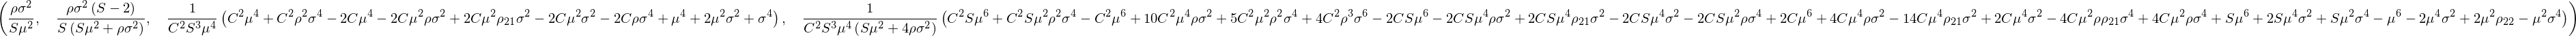

In [17]:
# 2.
print("Case 2: correlation variables, no specific diagonal.")
cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4)]

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 2a: correlation with Gaussian variables, no specific diagonal.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


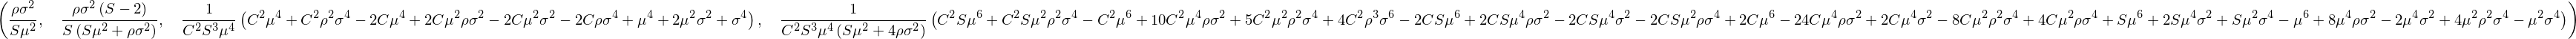

In [18]:
# 2a.
print("Case 2a: correlation with Gaussian variables, no specific diagonal.")
cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3: Constant diagonal `d` of order 1.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


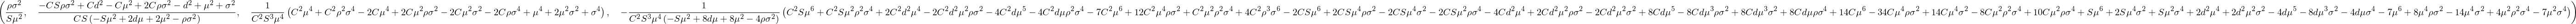

In [19]:
# 3.
print("Case 3: Constant diagonal `d` of order 1.")
d = sympy.symbols('d')
cond = [(mu_d, -d), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3a: Constant diagonal A_{ii} = -alpha * d_c
where d_c = (S - 1) * mu = critical d for mu > 0 ~ coorperation

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


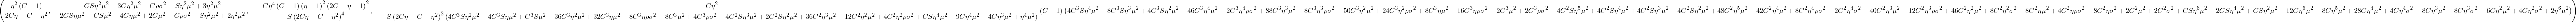

In [20]:
# 3a.
print("Case 3a: Constant diagonal A_{ii} = -eta * d_c")
print("where d_c = (S - 1) * mu = critical d for mu > 0 ~ coorperation")

# Critical d:
d_c     = (S - 1) * mu
# Factor on d_c
eta   = sympy.symbols('eta')
cond = [(mu_d, -eta * d_c), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3b: Constant diagonal A_{ii} = -alpha * d_c
where d_c = sqrt(sigma**2 * 2 * S) - mu = critical d for mu < 0 ~ competition

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


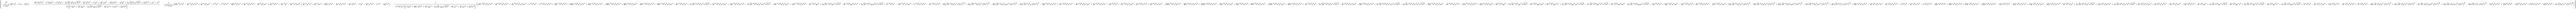

In [21]:
# 3b.
print("Case 3b: Constant diagonal A_{ii} = -alpha * d_c")
print("where d_c = sqrt(sigma**2 * 2 * S) - mu = critical d for mu < 0 ~ competition")

# Critical d:
d_c     = sympy.sqrt(mu2 * 2 * S) - mu
# Factor on d_c
eta   = sympy.symbols('eta')
cond = [(mu_d, -eta * d_c), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

In [22]:
# Save results in pickle file

results = {"E_d":      E_d, 
           "E_n":      E_n,
           "E_d_sq":   E_d_sq,
           "E_nd":     E_nd,
           "E_n_sq":   E_n_sq}

import sys
if int(sys.version[0]) == 2:
    import cPickle as pickle
else:
    import pickle

results_file = 'sympy_results_sparse.pkl'

with open(results_file, 'wb') as f:
    pickle.dump(results, f)
    
# # Test    
# with open(results_file, 'rb') as f:
#     lr = pickle.load(f)
    
# ed = lr['E_d']
# type(ed)


# Non-sparse: $C = 1$

In [23]:
cond_non_sparse = [(C, 1)]


Case 0: Full variance, no further conditions.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


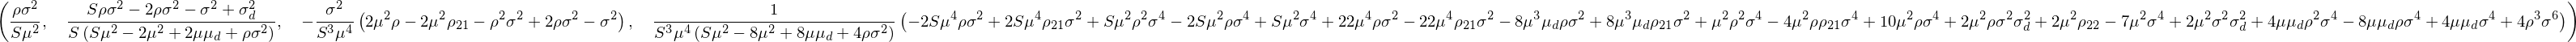

In [24]:
# 0.
print("Case 0: Full variance, no further conditions.")

cond = cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 1: All A_ij iid.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


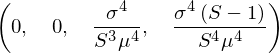

In [25]:
# 1.
print("Case 1: All A_ij iid.")
cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4), (rho, 0), (rho_21, 0), (rho_22, 0), (rho_31, 0)]
cond += cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 2: correlation variables, no specific diagonal, Gaussian random matrix.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


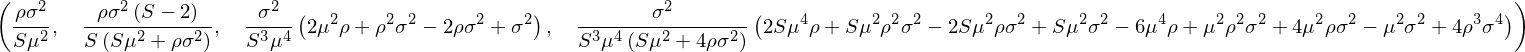

In [26]:
# 2.
print("Case 2: correlation variables, no specific diagonal, Gaussian random matrix.")
cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho
cond += cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3: Constant diagonal `d` of order 1.

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


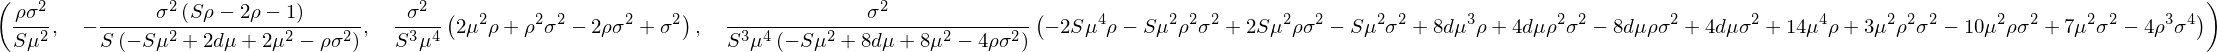

In [28]:
# 3.
print("Case 3: Constant diagonal `d` of order 1.")
d = sympy.symbols('d')
cond = [(mu_d, -d), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho
cond += cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3a: Constant diagonal A_{ii} = -eta * d_c
where d_c = (S - 1) * mu = critical d for mu > 0 ~ coorperation

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


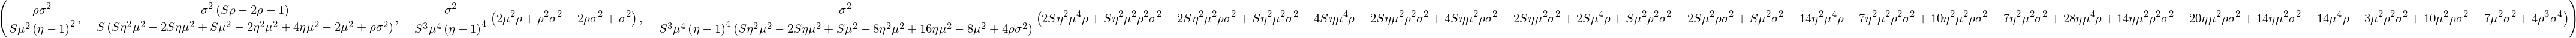

In [29]:
# 3a.
print("Case 3a: Constant diagonal A_{ii} = -eta * d_c")
print("where d_c = (S - 1) * mu = critical d for mu > 0 ~ coorperation")

# Critical d:
d_c     = (S - 1) * mu
# Factor on d_c
eta   = sympy.symbols('eta')
cond = [(mu_d, -eta * d_c), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho
cond += cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

Case 3b: Constant diagonal A_{ii} = -alpha * d_c
where d_c = sqrt(sigma**2 * 2 * S) - mu = critical d for mu < 0 ~ competition

Expected value: 1st & 2nd order; Variance: 1st & 2nd order.


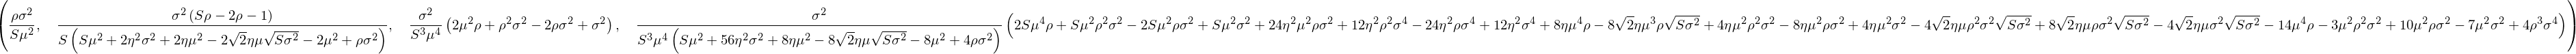

In [30]:
# 3b.
print("Case 3b: Constant diagonal A_{ii} = -alpha * d_c")
print("where d_c = sqrt(sigma**2 * 2 * S) - mu = critical d for mu < 0 ~ competition")

# Critical d:
d_c     = sympy.sqrt(mu2 * 2 * S) - mu
# Factor on d_c
eta   = sympy.symbols('eta')
cond = [(mu_d, -eta * d_c), (mu_d2, 0), (mu_d3, 0), (mu_d4, 0)]
cond_rho = [
            (rho_21, 2 * rho), 
#             (rho_21, 2 * rho * mu * mu2), 
            (rho_22, 2 * (2 * mu2 * mu**2 * rho + (mu2 * rho)**2)), 
            (rho_31, -mu3 * mu + 3 * mu2 * mu**2 + 3 * mu2 * rho * (mu2 + mu**2))]
cond += cond_rho
cond += cond_non_sparse

eval_specific_case(E_n, E_d, full_num, full_den, cond, show_order=1)

In [27]:
assert False, "Dont run the stuff below..."

AssertionError: Dont run the stuff below...

# Previous results (only $A_{ij}$ iid) -- remain here for comparison.

In [ ]:
### Define functions


def generate_consistent_index_matrices(dim_P):
    """ Generate all possible iterations (only upper triangular matrices) 
    and throw away all inconsistent ones. If matrix is kept, set diagonal elements to `True`.
    """
    # Make sure you're not filling the memory completely...
    assert dim_P <= 7, "Larger dim_P takes too long."
    # Number of entries in upper triangular matrix without diagonal
    red_dim = dim_P * (dim_P - 1) / 2
    # Iterate over all possible realizations
    Ps = []
    for entries in it.product([True, False], repeat = red_dim):
        P = np.zeros((dim_P, dim_P), dtype=bool)
        for i in range(dim_P - 1):
            si = sum(range(dim_P - 1 - i, dim_P - 1))
            P[i, i+1:] = entries[i + si: si + dim_P - 1]
    
        # Throw away inconsistent ones
        throw_away = False
        for x in range(dim_P-1):
            for y in range(x + 1, dim_P):
                for z in range(y + 1, dim_P):
                    if P[x, y] or P[x, z]:
                        if (P[x, y] and P[x, z]) != P[y, z]:
                            throw_away = True
                            break
                if throw_away:
                    break
            if throw_away:
                break
        if not throw_away:
            np.fill_diagonal(P, True)
            Ps.append(P)
            
    return Ps

def calc_cliques(Ps):
    sorted_clique_lengths = []
    m_Ps = np.zeros(len(Ps), dtype=int)
    
    dim_P = len(Ps[0])

    for j, P in enumerate(Ps):
        indices = set(range(dim_P))
        
        # Initial clique containing the first index
        cliques = [set([y for y, P_0_y in enumerate(P[0]) if P_0_y])]

        # Form other cliques
        for i in range(dim_P):
            if set.union(*cliques) == indices:
                break
            else:
                idx = min(indices - set.union(*cliques))
                P_idx = P[idx, idx: ]
                cliques.append(set([y + idx for y, P_idx_y in enumerate(P_idx) if P_idx_y]))

        # Collapse cliques
        sorted_clique_len = np.sort([len(clique) for clique in cliques])[::-1]
        sorted_clique_lengths.append(tuple(sorted_clique_len))
        m_Ps[j] = len(sorted_clique_len)
    
    return sorted_clique_lengths, m_Ps
        
def collapse_to_4d(Ps):
    dim_P = len(Ps[0])
    dim_R = 4
    Rs = np.zeros((len(Ps), dim_R, dim_R), dtype=bool)
    
    
    if dim_P == 6:
        # For denominator: collapse 6d to 4d
        for j, P in enumerate(Ps):
            R = np.zeros((dim_R, dim_R), dtype=bool)

            R[0, 1] = P[0, 4] and P[1, 4] #R[0, 1]
            R[0, 2] = P[0, 2] and P[4, 5] #R[0, 2]
            R[0, 3] = P[0, 5] and P[3, 4] #R[0, 3]
            R[1, 2] = P[2, 4] and P[1, 5] #R[1, 2]
            R[1, 3] = P[4, 5] and P[1, 3] #R[1, 3]
            R[2, 3] = P[2, 5] and P[3, 5] #R[2, 3]

            np.fill_diagonal(R, True)
            Rs[j] = R
    
    if dim_P == 7:
        # For den * num term: collapse 7d to 4d
        for j, P in enumerate(Ps):
            R = np.zeros((dim_R, dim_R), dtype=bool)

            R[0, 1] = P[0, 2] and P[1, 3] #R[0, 1]
            R[0, 2] = P[0, 4] and P[1, 6] #R[0, 2]
            R[0, 3] = P[0, 6] and P[1, 5] #R[0, 3]
            R[1, 2] = P[2, 4] and P[3, 6] #R[1, 2]
            R[1, 3] = P[2, 6] and P[3, 5] #R[1, 3]
            R[2, 3] = P[4, 6] and P[5, 6] #R[2, 3]

            np.fill_diagonal(R, True)
            Rs[j] = R
            
    return Rs
    
def get_unique_cliques_and_multiplicities(sorted_clique_lengths, m_Ps, dim_P):
    unique_scls = set(sorted_clique_lengths)
    list_scl_m_c = []
    m_factors_all = []
    for unique_scl in unique_scls:
        # Indices where the unique sorted clique length equals that of P in the list Ps
        idx = [j for j, scl in enumerate(sorted_clique_lengths) if scl == unique_scl]

        # Get the number of appearence of multiplicity factors S, S-1, S-2, ..., S-(dim_P-1)
        unique_m_P, counts = np.unique(m_Ps[idx], return_counts=True)
        m_factors = np.zeros(dim_P, dtype=int)
        m_factors[unique_m_P - 1] = counts

        # Append to a list containing the sored clique lengths and corresponding multiplicity factors
        list_scl_m_c.append([unique_scl, m_factors])
    #     print(unique_scl, m_factors)
        m_factors_all.append(m_factors)
    
    m_factors_all = np.asarray(m_factors_all)
    
    # Sort multiplicity factors
    m_factors_all = m_factors_all[np.argsort(list(unique_scls))[::-1]]
    return list_scl_m_c, m_factors_all

def print_results(list_scl_m_c):
    """ Print the results in a nice way (to understand what's going on).
    """
    dim_P = len(list_scl_m_c[0][1])

    names                           = ['X^4    ','X^3 Y  ', 'X^2 Y^2', 'X^2 Y Z', 'X Y Z U',    ]
    corresponding_clique_lengths    = [(4,),     (3, 1),    (2, 2),    (2, 1, 1), (1, 1, 1, 1), ]

    print(" "*11 + "Multipl. number m_P")
    m_p_str_title = ""
    for i in range(dim_P):
        m_p_str_title += "%5d"%(i+1)
    print("Cliques  " + m_p_str_title + " "*5 + " tuple")
    print("-"*60)

    for name, cl in zip(names, corresponding_clique_lengths):
        for scl_m_c in list_scl_m_c:
            if scl_m_c[0] == cl:
                m_str = ""
                for m_c in scl_m_c[1]:
                    m_str += "%5d"%m_c
                print(name + "  " + m_str + " "*5, scl_m_c[0])
    

def calc_expected_value(m_factors_all, S):
    dim_P = m_factors_all.shape[1]
    j = sympy.symbols('j', integer=True)

    # Check-sum
    sum_S = 0
    for i in range(dim_P):
        prod_S = sympy.product(S-j, (j, 0, i))
        sum_S += prod_S * np.sum(m_factors_all, axis=0)[i]
    
    if S**dim_P == sympy.expand(sum_S):
        print("Checksum = ", sympy.expand(sum_S), "is ok!") # == S**6???

    # Calculate factors for expected value
    a = []
    for k in range(len(m_factors_all)):
        sum_S = 0
        for i in range(dim_P):
            prod_S = sympy.product(S-j, (j, 0, i))
            sum_S += prod_S * m_factors_all[k, i]
        a.append(sympy.expand(sum_S))
        
    print("\nMultiplicity factors:")
    for i, ai in enumerate(a):
        print("a_%d = "%i, ai)

    # Print out the entire term
    mu4, mu3, mu2, mu = sympy.symbols('mu4 mu3 mu2 mu')
    
    expected_value = (mu4         * a[0] + 
                      mu3 * mu    * (4*a[0] + a[1]) + 
                      mu2**2      * a[2] + 
                      mu2 * mu**2 * (6*a[0] + 3*a[1] + 2*a[2] + a[3]) + 
                      mu**4       * sum(a))
    
    return expected_value


## Calculate expected values of $n^2$, $d^2$ and $n \cdot d$.

In [ ]:
# Calculate n^2 term
# Reduced to 4d, but running over $M = S^2$ entries. 
print("Calculate n^2 term\n")

dim = 4

Ps                          = generate_consistent_index_matrices(dim)

sorted_clique_lengths, m_Ps = calc_cliques(Ps)
        
list_scl_m_c, m_factors_all = get_unique_cliques_and_multiplicities(sorted_clique_lengths, m_Ps, dim)

print_results(list_scl_m_c)
    
M = S**2
E_n_sq_iid = calc_expected_value(m_factors_all, M)

print("\nE[n^2]:")
sympy.expand(E_n_sq_iid)

In [ ]:
# Calculate d^2 term
print("Calculate d^2 term\n")

dim = 6

Ps                          = generate_consistent_index_matrices(dim)

_, m_Ps                     = calc_cliques(Ps)
        
Rs                          = collapse_to_4d(Ps)
    
sorted_clique_lengths, _    = calc_cliques(Rs)

list_scl_m_c, m_factors_all = get_unique_cliques_and_multiplicities(sorted_clique_lengths, m_Ps, dim)

print_results(list_scl_m_c)
    
E_d_sq_iid = S**2 * calc_expected_value(m_factors_all, S)

print("\nE[d^2]:")
sympy.expand(E_d_sq_iid)

In [ ]:
# Calculate n*d term
print("Calculate n * d term\n")

dim = 7

Ps                          = generate_consistent_index_matrices(dim)

_, m_Ps                     = calc_cliques(Ps)

Rs                          = collapse_to_4d(Ps)
    
sorted_clique_lengths, _    = calc_cliques(Rs)

list_scl_m_c, m_factors_all = get_unique_cliques_and_multiplicities(sorted_clique_lengths, m_Ps, dim)

print_results(list_scl_m_c)
    
E_nd_iid = S * calc_expected_value(m_factors_all, S)

print("\nE[n*d]:")
sympy.expand(E_nd_iid)

## Put everything together

In [ ]:
# Putting everything together
print("\nE[n^2 - 2*n*d + d^2]:")
num_iid = sympy.expand((E_n_sq_iid - 2 * E_nd_iid + E_d_sq_iid))
print(num_iid)

print("\nE[d^2]:")
den_iid = sympy.expand(E_d_sq_iid)
print(den_iid)

cond = [(mu_d, mu), (mu_d2, mu2), (mu_d3, mu3), (mu_d4, mu4), (rho, 0), (rho_21, 0), (rho_22, 0), (rho_31, 0)]
eval_specific_case(E_n, E_d, num_iid, den_iid, cond, show_order=2)


# Snippets, old stuff

### Compute the expected value for $A_{ij}$ iid manually: 

Define errors in $x$ and $\beta$ direction:

> $\mathrm{err}_x = 1 - \frac{x(\beta_\mathrm{eff})}{x_\mathrm{eff}}$

> $\mathrm{err}_\beta = 1 - \frac{\beta(x_\mathrm{eff})}{\beta_\mathrm{eff}}$

For the GLV, the coincide:

> $x(\beta_\mathrm{eff}) = - \frac{\alpha}{\beta_\mathrm{eff}}$, 

such that 

> $ \mathrm{err} = 1 + \frac{\alpha}{x_\mathrm{eff} \beta_\mathrm{eff}}$ .

Inserting the definitions of $x_\mathrm{eff}$ and $\beta_\mathrm{eff}$ from Gao et al.'s paper, 

> $ x_\mathrm{eff} = \frac{\sum_{ij} A_{ij} x_j}{\sum_{mn} A_{mn}}  $, 

> $ \beta_\mathrm{eff} = \frac{\sum_{ijk} A_{ij} A_{jk} }{\sum_{mn} A_{mn}} $, 

we get 

> $
    \mathrm{err} = 1 + \frac{
        \alpha \left(\sum_{mn} A_{mn}\right) \left(\sum_{mn} A_{mn}\right) 
        }{
        - \alpha \left( \sum_{ijk} A_{ij} {A^{-1}}_{jk} \right) \left(\sum_{ijk} A_{ij} A_{jk}\right)} = 1 - \frac{\sum_{ijkl} A_{ij} A_{kl} }{ S \sum_{ijk} A_{ij} A_{jk} }$


Now, if all entries are drawn independently from one distribution, $A_{ij} \sim p(\mu, \sigma^2)$,
one can calculate the expected value 

> $\mathbb{E}\left[ \mathrm{err} \right] 
    = 1 - \mathbb{E} \left[\frac{\sum_{ijkl} A_{ij} A_{kl} }{ S \sum_{ijk} A_{ij} A_{jk} }\right]   $ .
    
This cannot be calculated directly. If, however, we assume the denominator ot be much larger than zero, we might be able to approximate by taking the expected values separately -- this is what we shall test numerically. However, doing this separation yields

> $ \mathbb{E} \left[ \sum_{ijkl} A_{ij} A_{kl} \right]
    = \mathbb{E} \left[
    \sum_{(i, j) \ne (k, l)} A_{ij} A_{jk} + \sum_{(i, j)} A_{ij}^2 \right]
    = (S^4  - S^2) \mu^2 + S^2(\sigma^2 + \mu^2)
    = S^2(S^2 \mu^2 + \sigma^2)
$

and

> $ \mathbb{E} \left[ \sum_{ijk} A_{ij} A_{jk} \right] 
    = \mathbb{E} \left[\sum_{j, i \ne k} A_{ij} A_{jk} + \sum_{j \ne i} A_{ij} A_{ji} + \sum_{i} A_{ii}^2 \right]
    = S^2 (S - 1) \mu^2 + S (S - 1) \mu^2 + S (\sigma^2 + \mu ^ 2) 
    = S(S^2 \mu^2 + \sigma^2) $

which gives 

> $ 1 - \frac{ \mathbb{E} \left[ \sum_{ijkl} A_{ij} A_{kl} \right]} 
{S \mathbb{E} \left[ \sum_{ijk} A_{ij} A_{jk} \right]}
= 1 - \frac{S^2(S^2 \mu^2 + \sigma^2)}{S^2 (S^2 \mu^2 + \sigma^2)} = 0 $.

So, either this approximation does not hold or higher order terms are important.

In [ ]:
def print_unique_indicators(indicators):
    sa = set(indicators[:, 0])
    lsa = list(sa)

    print("#    Indicator tuple       n_diags     Variable combination")
    print("___________________________________________________________")
    for j, ind in enumerate(lsa):
        i_str = ""
        nd = int(ind[-1])
        for i in range(4):
            i_str += ['X', 'Y', 'Z', 'U'][int(np.floor(ind[i]))]

            if i < 4 - nd:
                # Off-diagonals
                ind_i = ind[i]
                if round(ind_i - round(ind_i, 0), 1) == 0.1:
                    i_str += '^T'
                else:
                    i_str += '  '
            else:
                # Diagonals
                i_str += '_d'

            i_str += '  '

        print("%2d   (%.1f, %.1f, %.1f, %.1f)        %1d       %s"%(
                j, ind[0], ind[1], ind[2], ind[3], ind[4], i_str))